In [22]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import statistics
import sklearn
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [11]:
model = BaggingClassifier(base_estimator=LogisticRegression(C= 0.9, max_iter=1000), n_estimators=30, max_samples=1.0, max_features=1.0, bootstrap=True,
             bootstrap_features=True, oob_score=True, warm_start=False).fit(X, y)

In [ ]:
# cols- esti1 est2
# row: 

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
for i in model.estimators_:
    print(i.predict_proba(x_test)[:, 1][:10])
    break

[0.17266655 0.69622027 0.45361579 0.74861356 0.15033304 0.35837374
 0.21372555 0.39190657 0.32551794 0.00886413]


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [28]:
statistics.variance([1,2,3])

1

In [54]:
def ensemble(X, y, base_estimator=LogisticRegression(C= 0.9, max_iter=1000), n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True,
             bootstrap_features=True, oob_score=True, warm_start=False, **kwargs):
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    
    model = BaggingClassifier(base_estimator=base_estimator, n_estimators=n_estimators,
                              max_samples=max_samples, max_features=max_features, 
                              bootstrap=bootstrap, bootstrap_features=bootstrap_features,
                              oob_score=bootstrap_features)
    
    
    model.fit(x_train, y_train)
    
    y_preds = model.predict(x_test)
    y_probs = model.predict_proba(x_test)
    #print(x_test.shape)
    #print(y_probs.shape)
    #print(y_probs)
    

#     acc = accuracy_score(y_test, y_preds)
    #ece = expected_calibration_error(y_test, y_probs)
    
#     reliability_diagram(y_test, y_probs)

    probs = pd.DataFrame()
    i = 1
    for mod in model.estimators_:
        probs1 = mod.predict_proba(x_test)[:, 1] # probabilities of input being classified as 1
        probs[f'mod{i}'] = probs1
        i+=1
    
    var_predictions = probs.var(axis=1)
    var_models = probs.var(axis=0)
    
    return model, y_probs, probs, var_models, var_predictions

In [55]:
model, y_probs, probs, var_models, var_predictions = ensemble(X, y)

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:747: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:753: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\b

In [47]:
var_models

mod1     5.372244e-02
mod2     4.132188e-15
mod3     6.943371e-15
mod4     7.158050e-02
mod5     6.420064e-02
mod6     2.141553e-01
mod7     4.132117e-05
mod8     1.618603e-01
mod9     2.940910e-07
mod10    7.927320e-06
dtype: float64

In [50]:
var_predictions[:2] # variance of output of estimators for each prediction.

0    0.097567
1    0.126154
dtype: float64

In [67]:
y_probs[:,1][:10]

array([0.2720334 , 0.83771572, 0.80212482, 0.33710311, 0.02793165,
       0.61288317, 0.33870606, 0.4695425 , 0.27963184, 0.26975782])

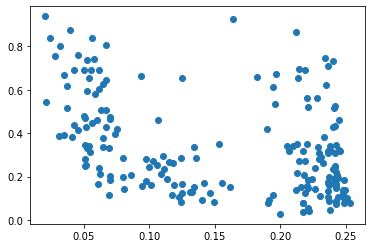

In [66]:
plt.scatter(var_predictions, y_probs[:,1])


# colors = plt.cm.get_cmap("Dark2")

# plt.hist(
#     y_probs[:,1],
#     range=(0, 1),
#     bins=10)

In [5]:
def expected_calibration_error(y_true, y_pred, num_bins=15):
    "y_preds should contain list of probabilities. More bins reduce the bias, but increase the variance "
    pred_y = np.argmax(y_pred, axis=-1)
    correct = (pred_y == y_true).astype(np.float32)
    prob_y = np.max(y_pred, axis=-1)

    b = np.linspace(start=0, stop=1.0, num=num_bins)
    bins = np.digitize(prob_y, bins=b, right=True)

    o = 0
    for b in range(num_bins):
        mask = bins == b
        if np.any(mask):
            o += np.abs(np.sum(correct[mask] - prob_y[mask]))

    return o / y_pred.shape[0], accuracy_score(y_true, pred_y)

In [6]:
def reliability_diagram(y_true, y_pred, label='LogisticRegression'):
    x, y = expected_calibration_error(y_true, y_pred)

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(x, y, "s-", label=label)

    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.title("Reliability diagram / calibration curve")

    plt.tight_layout()
    plt.show()

In [18]:
0.8*0.2

0.16000000000000003

In [9]:
lr = LogisticRegression(C=1.0)
clf_list = [(lr, "Logistic")]

X = df.drop('Outcome', axis=1)
y = df['Outcome']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


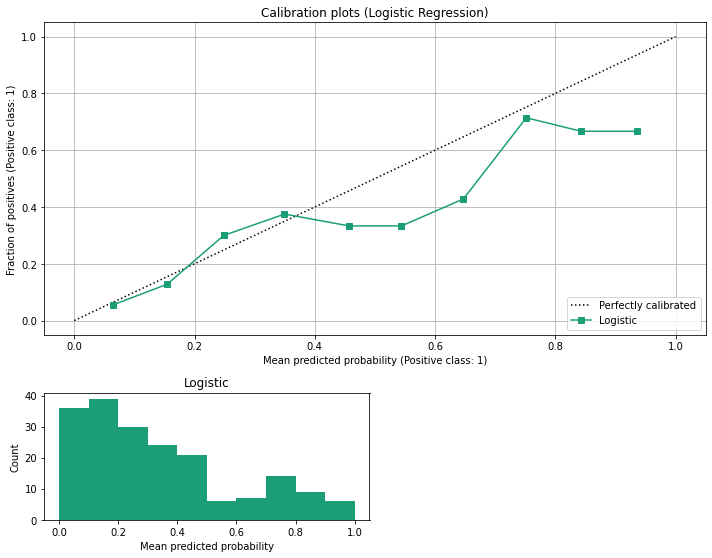

In [75]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(x_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        x_test,,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Logistic Regression)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()